In [ ]:
# Google Drive bağlantısı
from google.colab import drive
drive.mount('/content/drive')






Mounted at /content/drive


In [ ]:
# Gerekli kütüphaneleri yükle
!pip install -q matplotlib scikit-learn

In [ ]:
import zipfile
import os

# Zip dosyasının yolu
zip_path = '/content/drive/MyDrive/balanced_covid_dataset.zip'

# Çıkartılacak klasör yolu
extract_path = '/content/balanced_covid_dataset'

# Zip dosyasını aç ve tüm içeriği çıkart
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Çıkarılan klasörün içeriğini kontrol et
print("Klasör içeriği:")
print(os.listdir(extract_path))


Klasör içeriği:
['balanced_covid_dataset']


In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan cihaz: {device}")


Kullanılan cihaz: cuda


In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# === Görüntü ön işleme ===
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# === Ana klasör yolu (ZIP'ten çıkarılan) ===
extract_path = '/content/balanced_covid_dataset'

# === İçindeki alt klasör varsa (örneğin 'balanced_covid_dataset/balanced_covid_dataset') yakala ===
subfolders = os.listdir(extract_path)
if len(subfolders) == 1 and os.path.isdir(os.path.join(extract_path, subfolders[0])):
    data_dir = os.path.join(extract_path, subfolders[0])
else:
    data_dir = extract_path

# === Veri kümesini yükle (etiketleri klasör adına göre alır) ===
dataset = datasets.ImageFolder(data_dir, transform=data_transforms)

# === Eğitim ve doğrulama setine ayır ===
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# === Dataloader ===
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# === Etiketleri yazdır ===
class_names = dataset.classes
print(f"Sınıflar: {class_names}")



Sınıflar: ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


In [ ]:
import os

# Eğer içinde klasör varsa alt klasörü bul ve ata
subfolders = os.listdir(extract_path)
print("Alt klasörler:", subfolders)

# Sadece bir alt klasör varsa (örneğin: balanced_covid_dataset), onu kullan
if len(subfolders) == 1:
    data_dir = os.path.join(extract_path, subfolders[0])
else:
    data_dir = extract_path

dataset = datasets.ImageFolder(data_dir, transform=data_transforms)
print("Sınıflar:", dataset.classes)


Alt klasörler: ['balanced_covid_dataset']
Sınıflar: ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


In [ ]:
model = models.resnet50(pretrained=True)

# Son katmanı kendi sınıf sayımıza göre güncelle
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 31.2MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # → [32, 112, 112]
        x = self.pool(F.relu(self.conv2(x)))   # → [64, 56, 56]
        x = x.view(x.size(0), -1)              # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(class_names)
model = ImprovedCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)

num_epochs = 50
patience = 3
best_val_loss = float('inf')
patience_counter = 0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_losses.append(train_loss / total)
    train_accuracies.append(train_acc)

    # === Validation ===
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_losses.append(val_loss / total)
    val_accuracies.append(val_acc)

    scheduler.step(val_losses[-1])

    print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⛔ Early stopping triggered.")
            break

# En iyi modeli geri yükle
model.load_state_dict(best_model_state)


Epoch 1/50 | Train Acc: 0.5575 | Val Acc: 0.6750
Epoch 2/50 | Train Acc: 0.6684 | Val Acc: 0.7562
Epoch 3/50 | Train Acc: 0.7459 | Val Acc: 0.7987
Epoch 4/50 | Train Acc: 0.7953 | Val Acc: 0.8013
Epoch 5/50 | Train Acc: 0.8231 | Val Acc: 0.8150
Epoch 6/50 | Train Acc: 0.8469 | Val Acc: 0.8325
Epoch 7/50 | Train Acc: 0.8753 | Val Acc: 0.8275
Epoch 8/50 | Train Acc: 0.8881 | Val Acc: 0.8275
Epoch 9/50 | Train Acc: 0.9187 | Val Acc: 0.8500
Epoch 10/50 | Train Acc: 0.9350 | Val Acc: 0.8562
Epoch 11/50 | Train Acc: 0.9428 | Val Acc: 0.8500
Epoch 12/50 | Train Acc: 0.9572 | Val Acc: 0.8538
⛔ Early stopping triggered.


<All keys matched successfully>

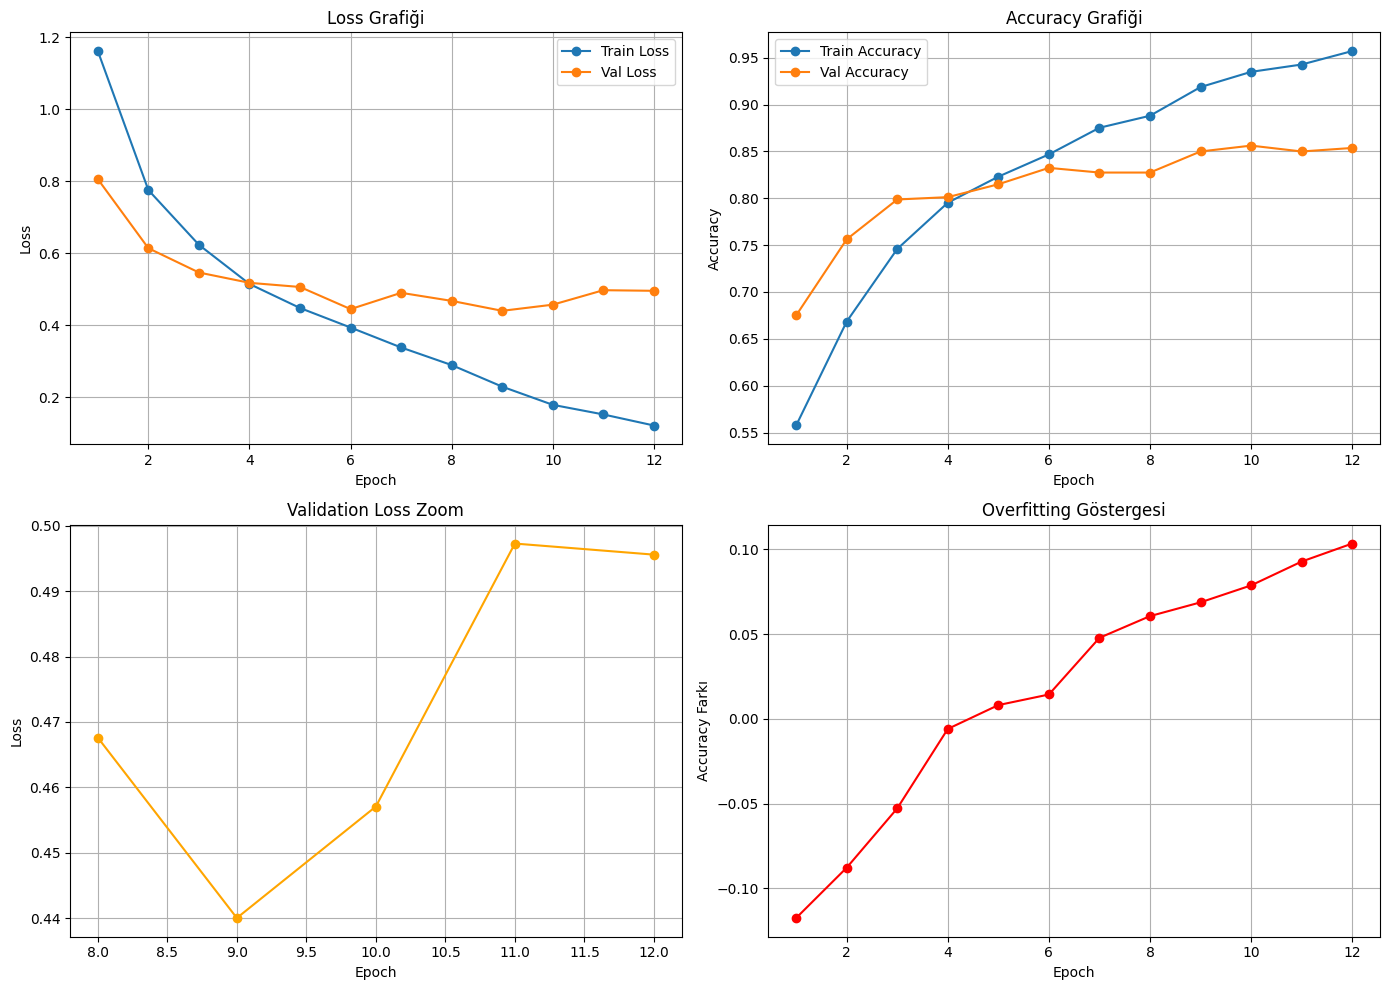

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 10))

# 1. Train & Validation Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", marker='o')
plt.plot(epochs, val_losses, label="Val Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Grafiği")
plt.legend()
plt.grid(True)

# 2. Train & Validation Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy", marker='o')
plt.plot(epochs, val_accuracies, label="Val Accuracy", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Grafiği")
plt.legend()
plt.grid(True)

# 3. Val Loss Zoom (son 5 epoch)
plt.subplot(2, 2, 3)
plt.plot(epochs[-5:], val_losses[-5:], label="Val Loss (Son 5)", color='orange', marker='o')
plt.title("Validation Loss Zoom")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# 4. Accuracy farkı
plt.subplot(2, 2, 4)
acc_diff = [train - val for train, val in zip(train_accuracies, val_accuracies)]
plt.plot(epochs, acc_diff, label="Train - Val Accuracy Farkı", color='red', marker='o')
plt.title("Overfitting Göstergesi")
plt.xlabel("Epoch")
plt.ylabel("Accuracy Farkı")
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


📊 Classification Report:

                 precision    recall  f1-score   support

          COVID       0.87      0.90      0.89       207
   Lung_Opacity       0.79      0.75      0.77       199
         Normal       0.78      0.80      0.79       198
Viral Pneumonia       0.97      0.96      0.97       196

       accuracy                           0.85       800
      macro avg       0.85      0.85      0.85       800
   weighted avg       0.85      0.85      0.85       800



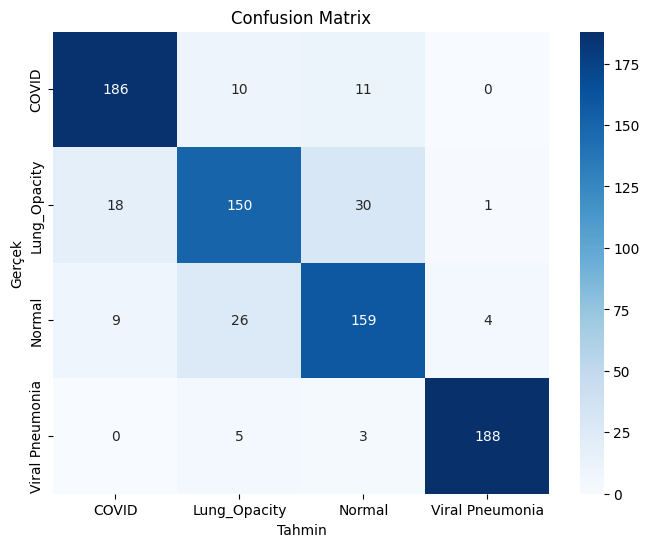

In [ ]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix ve Rapor
cm = confusion_matrix(all_labels, all_preds)
print("📊 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
!pip uninstall grad-cam -y
!pip install grad-cam==1.4.8


Found existing installation: grad-cam 1.4.8
Uninstalling grad-cam-1.4.8:
  Successfully uninstalled grad-cam-1.4.8
  Using cached grad_cam-1.4.8-py3-none-any.whl


NameError: name 'model' is not defined

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 4  # Veya: len(class_names)

model = ImprovedCNN(num_classes).to(device)

# Eğer eğitim sonrası kaydettiysen:
# torch.save(model.state_dict(), "model.pt")
# Onu yükle:
# model.load_state_dict(torch.load("model.pt"))

# Eğer eğitimden sonra model bellekteyse, bu adım yeterli.
model.eval()


ImprovedCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [ ]:
# === 1. GEREKLİ KÜTÜPHANELER ===
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# === 2. CNN MODELİNİ TANIMLA (EĞİTTİĞİN MODEL) ===
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# === 3. MODELİ OLUŞTUR ve YÜKLE ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']  # sıralı olmalı
num_classes = len(class_names)
model = ImprovedCNN(num_classes).to(device)

# Daha önce eğittiysen, model ağırlığını yükle (varsa):
# model.load_state_dict(torch.load("/content/model.pt"))

model.eval()  # inference modunda çalıştır

# === 4. DÖNÜŞÜM TANIMLA ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# === 5. VERİ SETİ YOLUNU AYARLA ===
root_dir = "/content/balanced_covid_dataset/images"  # burası doğrudan COVID/ klasörlerinin olduğu yer olmalı
num_samples = 5

# === 6. GRAD-CAM HAZIRLIĞI ===
target_layer = model.conv2
cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=torch.cuda.is_available())

# === 7. HER SINIFTAN 5 GÖRSELİ GÖSTER ===
for class_idx, class_name in enumerate(class_names):
    class_path = os.path.join(root_dir, class_name)
    image_paths = sorted(glob.glob(os.path.join(class_path, "*")))[:num_samples]

    for img_path in image_paths:
        try:
            image = Image.open(img_path).convert("RGB")
        except:
            print(f"Hatalı dosya: {img_path}")
            continue

        input_tensor = transform(image).unsqueeze(0).to(device)
        rgb_image = np.array(image.resize((224, 224))) / 255.0

        grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(class_idx)])[0]
        visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

        # Görselleştir
        plt.figure(figsize=(4, 4))
        plt.imshow(visualization)
        plt.title(f"{class_name}")
        plt.axis('off')
        plt.show()



🔎 COVID sınıfından 5 görsel alındı.


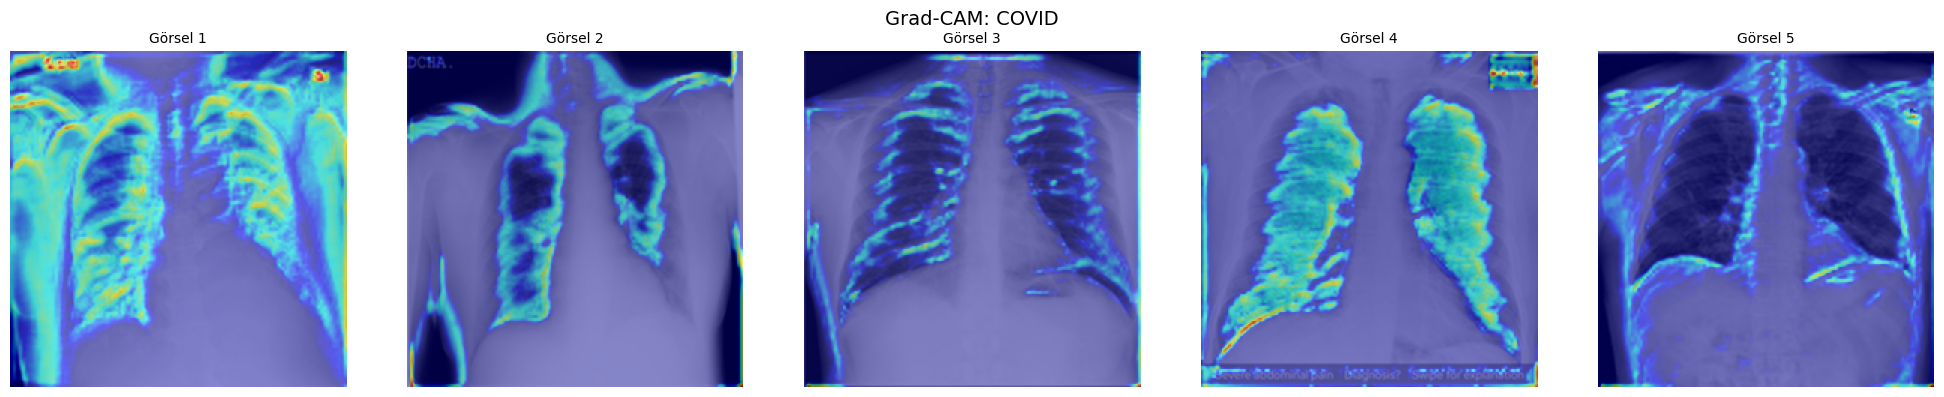


🔎 Lung_Opacity sınıfından 5 görsel alındı.


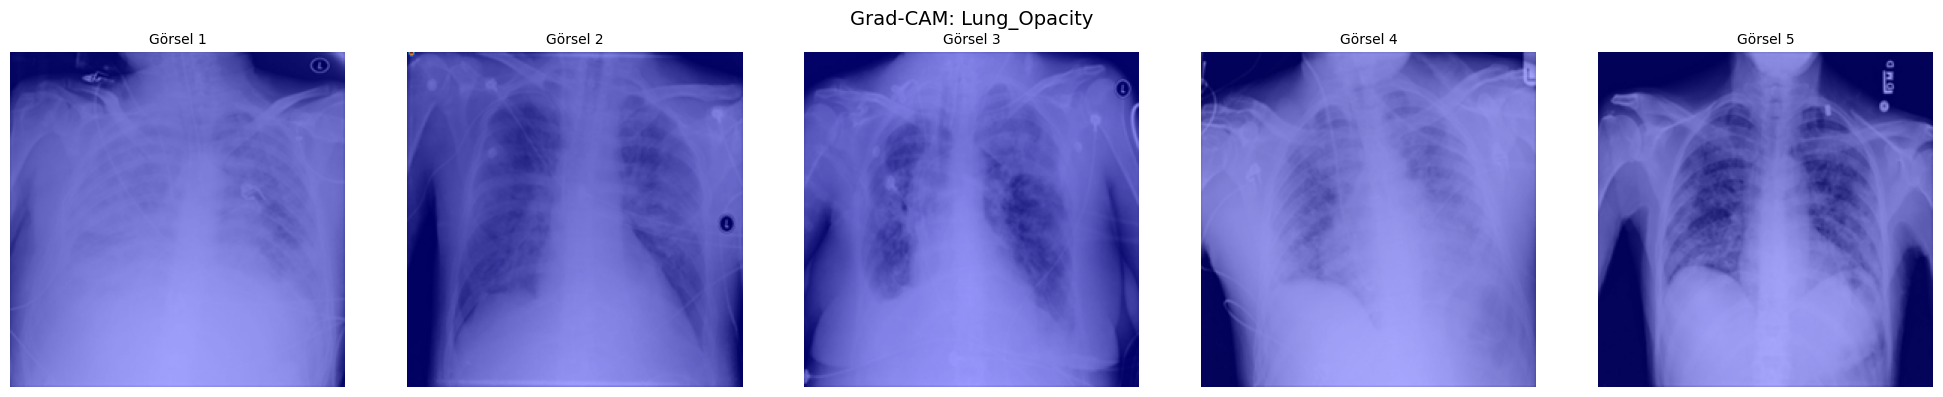


🔎 Normal sınıfından 5 görsel alındı.


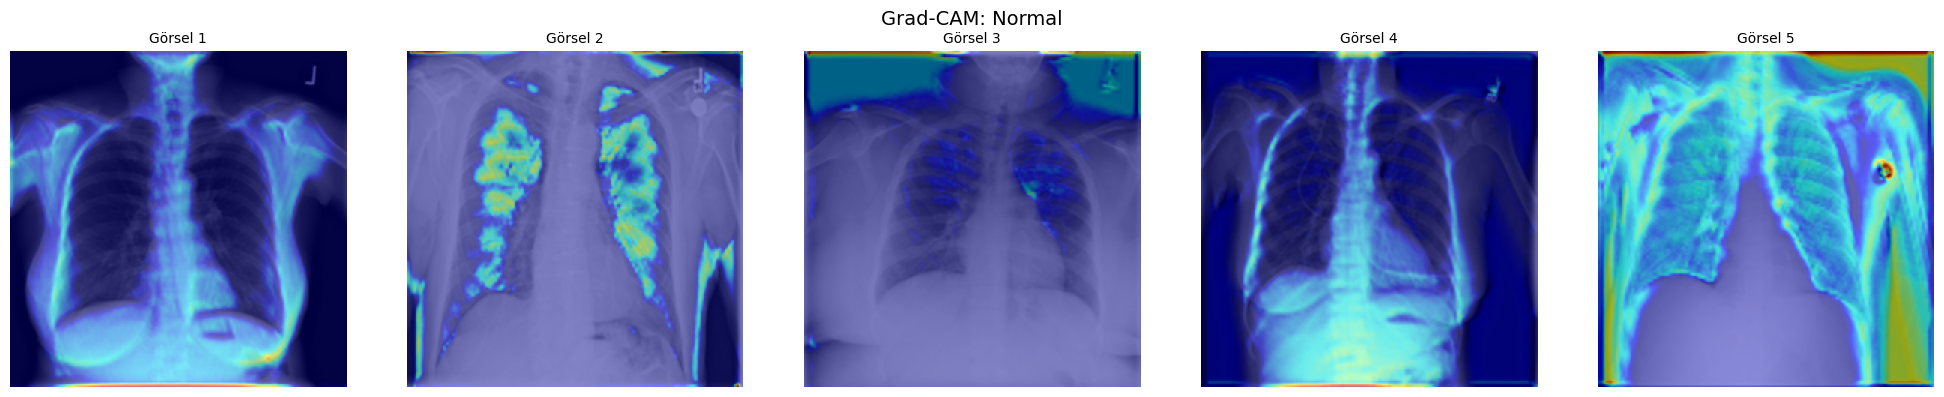


🔎 Viral Pneumonia sınıfından 5 görsel alındı.


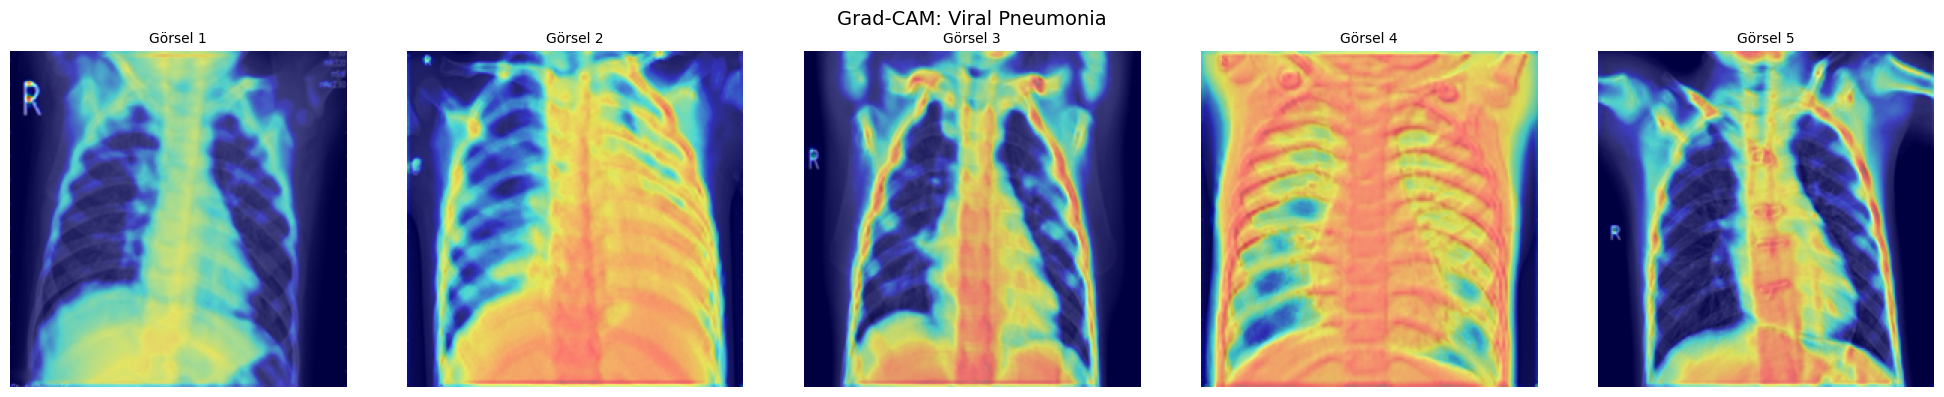

In [ ]:
# === GEREKLİ KÜTÜPHANELER ===
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# === MODEL TANIMI ===
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# === MODELİ OLUŞTUR ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
model = ImprovedCNN(num_classes=len(class_names)).to(device)
model.eval()

# === VERİ DÖNÜŞÜMÜ ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# === VERİ SETİ ANA DİZİNİ ===
data_dir = "/content/drive/MyDrive/balanced_covid_dataset/balanced_covid_dataset"
target_layer = model.conv2
cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=torch.cuda.is_available())

# === HER SINIF İÇİN 5 GÖRSELİ YATAY GÖSTER ===
for class_index, class_name in enumerate(class_names):
    class_path = os.path.join(data_dir, class_name)
    image_paths = sorted(glob.glob(os.path.join(class_path, "*.*")))[:5]

    print(f"\n🔎 {class_name} sınıfından {len(image_paths)} görsel alındı.")

    fig, axes = plt.subplots(1, len(image_paths), figsize=(20, 4))

    for idx, img_path in enumerate(image_paths):
        try:
            image = Image.open(img_path).convert("RGB")
            input_tensor = transform(image).unsqueeze(0).to(device)
            rgb_image = np.array(image.resize((224, 224))) / 255.0

            grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(class_index)])[0]
            visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

            axes[idx].imshow(visualization)
            axes[idx].set_title(f"Görsel {idx+1}", fontsize=10)
            axes[idx].axis('off')

        except Exception as e:
            print(f"HATA ({img_path}):", e)

    plt.suptitle(f"Grad-CAM: {class_name}", fontsize=14)
    plt.tight_layout()
    plt.show()


In [ ]:
!cp improved_cnn_best_model.pt /content/drive/MyDrive/benim_model_klasorum/


cp: cannot stat 'improved_cnn_best_model.pt': No such file or directory


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from torch.utils.data import DataLoader
import copy

In [ ]:
# Google Drive'ı mount et
from google.colab import drive
drive.mount('/content/drive')

# Veri seti yolu
data_dir = "/content/drive/MyDrive/balanced_covid_dataset/balanced_covid_dataset"

# Veri seti klasörünün varlığını kontrol et
if os.path.exists(data_dir):
    print(f"✅ Veri seti bulundu: {data_dir}")

    # Alt klasörleri (sınıfları) listele
    subfolders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]
    subfolders.sort()  # Alfabetik sırala
    print(f"📁 Sınıf klasörleri: {subfolders}")

    # Her sınıftaki görüntü sayısını say
    total_images = 0
    class_counts = {}
    print("\n📊 Sınıf başına görüntü sayıları:")

    for folder in subfolders:
        folder_path = os.path.join(data_dir, folder)
        # Yaygın görüntü formatlarını say
        image_files = [f for f in os.listdir(folder_path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
        image_count = len(image_files)
        total_images += image_count
        class_counts[folder] = image_count
        print(f"  {folder}: {image_count} görüntü")

    print(f"\n🖼️ Toplam görüntü sayısı: {total_images}")

    # Sınıf dağılımını görselleştir
    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_counts.keys(), class_counts.values(),
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    plt.title('Sınıf Başına Görüntü Dağılımı', fontsize=14, fontweight='bold')
    plt.xlabel('Sınıflar')
    plt.ylabel('Görüntü Sayısı')
    plt.xticks(rotation=45)

    # Değerleri çubukların üzerine yaz
    for bar, count in zip(bars, class_counts.values()):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                str(count), ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.grid(True, alpha=0.3)
    plt.show()

else:
    print("❌ HATA: Veri seti klasörü bulunamadı!")
    print(f"Aranan yol: {data_dir}")
    print("Lütfen veri seti yolunu kontrol edin.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


NameError: name 'os' is not defined

In [ ]:
# Veri dönüşümleri
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Cihaz seçimi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔧 Kullanılan cihaz: {device}")

if device.type == 'cuda':
    print(f"🚀 GPU Belleği: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    print(f"🔋 Mevcut GPU Belleği: {torch.cuda.memory_reserved(0) / 1024**3:.1f} GB")

print("✅ Veri dönüşümleri hazırlandı!")
print("📋 Eğitim için kullanılacak augmentasyonlar:")
print("  - Resize (224x224)")
print("  - Random Rotation (±10°)")
print("  - Random Horizontal Flip")
print("  - Color Jitter")
print("  - Random Affine")
print("  - Normalization")

🔧 Kullanılan cihaz: cuda
🚀 GPU Belleği: 14.7 GB
🔋 Mevcut GPU Belleği: 0.0 GB
✅ Veri dönüşümleri hazırlandı!
📋 Eğitim için kullanılacak augmentasyonlar:
  - Resize (224x224)
  - Random Rotation (±10°)
  - Random Horizontal Flip
  - Color Jitter
  - Random Affine
  - Normalization


In [ ]:
# Veri setlerini yükle
if 'data_dir' in locals() and data_dir and os.path.exists(data_dir):
    try:
        # Tam veri setini yükle
        full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])
        class_names = full_dataset.classes
        num_classes = len(class_names)

        print(f"🏷️ Sınıf etiketleri: {class_names}")
        print(f"📈 Sınıf sayısı: {num_classes}")
        print(f"🖼️ Toplam görüntü sayısı: {len(full_dataset)}")

        # Sınıf dağılımını detaylı analiz
        print("\n📊 Detaylı sınıf dağılımı:")
        class_counts = {}
        for idx, (_, label) in enumerate(full_dataset):
            class_name = class_names[label]
            class_counts[class_name] = class_counts.get(class_name, 0) + 1

        # Sonuçları tablo halinde göster
        data_summary = []
        for class_name, count in class_counts.items():
            percentage = (count / len(full_dataset)) * 100
            data_summary.append({
                'Sınıf': class_name,
                'Görüntü Sayısı': count,
                'Yüzde': f"{percentage:.1f}%"
            })
            print(f"  {class_name}: {count} görüntü ({percentage:.1f}%)")

        # Pasta grafiği ile sınıf dağılımını göster
        plt.figure(figsize=(12, 5))

        # Pasta grafiği
        plt.subplot(1, 2, 1)
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
        wedges, texts, autotexts = plt.pie(class_counts.values(),
                                          labels=class_counts.keys(),
                                          autopct='%1.1f%%',
                                          colors=colors,
                                          startangle=90)
        plt.title('Sınıf Dağılımı', fontsize=14, fontweight='bold')

        # Bar grafiği
        plt.subplot(1, 2, 2)
        bars = plt.bar(class_counts.keys(), class_counts.values(), color=colors)
        plt.title('Sınıf Başına Görüntü Sayısı', fontsize=14, fontweight='bold')
        plt.xlabel('Sınıflar')
        plt.ylabel('Görüntü Sayısı')
        plt.xticks(rotation=45)

        # Değerleri çubukların üzerine yaz
        for bar, count in zip(bars, class_counts.values()):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
                    str(count), ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.show()

        print("✅ Veri seti başarıyla yüklendi ve analiz edildi!")

    except Exception as e:
        print(f"❌ Veri yükleme hatası: {e}")
        print("Lütfen veri seti yapısını kontrol edin.")

else:
    print("❌ HATA: Veri seti yolu tanımlanmadı veya bulunamadı!")

🏷️ Sınıf etiketleri: ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
📈 Sınıf sayısı: 4
🖼️ Toplam görüntü sayısı: 4000

📊 Detaylı sınıf dağılımı:


KeyboardInterrupt: 